In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# read csv file
insurance_df = pd.read_csv("Insurance_claims.csv")
# insurance_df.head()
insurance_df = insurance_df.drop(
    ["ReferenceId", "PolicyholderNumber", "InsurerNotes"], axis=1
)
# these are unique values which should be dropped and column about postcode and date will be dropped later
# we need to find those repeated values and set them into 1, others into 0(including the missing value)
mask = insurance_df["FirstPartyVehicleNumber"].duplicated()
insurance_df.loc[mask, "FirstPartyVehicleNumber"] = 1
insurance_df.loc[~mask, "FirstPartyVehicleNumber"] = 0


# check if there is thirdpartyvehicle, yes -> 1, no -> 0
insurance_df["ThirdPartyVehicleNumber"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].apply(
    lambda x: 1 if x > 0 else 0
)
insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(
    insurance_df["FirstPolicySubscriptionDate"]
)

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)
insurance_df = insurance_df.drop(["LossDate", "FirstPolicySubscriptionDate"], axis=1)
# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)
insurance_df = insurance_df.drop(["LossPostCode", "PolicyHolderPostCode"], axis=1)
# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=[
        "PolicyholderOccupation",
        "ClaimCause",
        "ClaimInvolvedCovers",
        "FirstPartyVehicleType",
        "ConnectionBetweenParties",
    ],
)

# check the two postcodes
def jud(x):
    if x == "TotalLoss":
        return 2
    elif x == "Medium":
        return 1
    else:
        return 0


insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna(0)
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].apply(
    lambda row: jud(row)
)

mean_v_fp = insurance_df["FpVehicleAgeMonths"].mean()
insurance_df["FpVehicleAgeMonths"] = insurance_df["FpVehicleAgeMonths"].fillna(
    value=mean_v_fp
)

insurance_df["LossHour"] = insurance_df["LossHour"].fillna(
    insurance_df["LossHour"].mean()
)
mean_v_po = insurance_df["PolicyHolderAge"].mean()
insurance_df["PolicyHolderAge"] = insurance_df["PolicyHolderAge"].fillna(mean_v_po)

# insurance_df["weight"] = insurance_df["Fraud"].apply(lambda x : 2 if x == 1 else 0)

In [3]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_other, Y_train, Y_other = train_test_split(
    X, y, train_size=0.7, random_state=111
)

X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_other, Y_other, test_size=0.5, random_state=111
)

X_train.shape, Y_train.shape

((8070, 121), (8070,))

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [5]:
def train_model(hp):

    n_hiddens = hp.Int("n_hiddens", min_value=2, max_value=24, step=1)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=512, step=8)
    dropout_rate = hp.Float("dropout_rate", min_value=0.01, max_value=1, step=0.01)
    learning_rate = hp.Float(
        "learning_rate", min_value=0.001, max_value=0.1, sampling="log"
    )
    
    model = tf.keras.Sequential(
        [
        tf.keras.layers.Flatten(input_shape=(121, 1))]
    )

    for _ in range(n_hiddens):
        
        model.add(
            tf.keras.layers.Dense(
                n_neurons,
                activation= tf.keras.layers.LeakyReLU(alpha=0.2),
                )
        )
        tf.keras.layers.BatchNormalization(),
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop", "sgd"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    METRICS = [
      tf.keras.metrics.MeanSquaredError(name='mse'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model.compile(
        # optimizer=optimizer, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
        optimizer=optimizer, loss='binary_crossentropy',
                  metrics=METRICS
    )

    return model

In [6]:
class ClassficationHyperModel(kt.HyperModel):
    def train(self, hp):
        return train_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)

        return model.fit(X, y, **kwargs)


In [7]:
# def create_plot(log):
#     plt.plot(log.history["rmse"], label="training rmse", color="red")
#     plt.plot(log.history["loss"], label="training loss", color="darkgreen")
#     plt.plot(
#         log.history["val_rmse"],
#         label="validation rmse",
#         color="grey",
#     )
#     plt.plot(log.history["val_loss"], label="validation loss", color="darkblue")
#     plt.legend()
#     plt.show()

In [8]:
def create_plot(log):
    plt.plot(log.history["accuracy"], label="training accuracy", color="red")
    plt.plot(log.history["loss"], label="training loss", color="darkgreen")
    plt.plot(
        log.history["val_accuracy"],
        label="validation accuracy",
        color="grey",
    )
    plt.plot(log.history["val_loss"], label="validation loss", color="darkblue")
    plt.legend()
    plt.show()

In [9]:
def opt_threshold(model):
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate the F1 score for different threshold values
    f1_scores = []
    thresholds = np.arange(0.0, 1.0, 0.01)
    for threshold in thresholds:
        y_pred_thresh = tf.keras.backend.cast(y_pred > threshold, 'float32')
        f1 = f1_score(Y_test, y_pred_thresh)
        f1_scores.append(f1)

    # Select the threshold with the highest F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    return optimal_threshold

def show_predicted_result(model, data):
    y_pred = model.predict(data)
    y_pred = y_pred.ravel()

    mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
    print("Mean square error: ", mse)

    opt_thresh = opt_threshold(model) 

    y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

    hits = sum(Y_test & y_pred)

    hit_rate = hits / np.sum(y_pred)
    detection_rate = np.sum(y_pred) / len(y_pred)


    print("Threshold-------------------------:", opt_thresh)
    print("Number of data in testset:--------:", len(y_pred))
    print("Number of predicted frauds--------:", np.sum(y_pred))
    print("Total number of frauds in testset-:", np.sum(Y_test))
    print("Number of predicted frauds hit----:", hits)
    print("Hit rate--------------------------:", hit_rate)
    print("Detection rate--------------------:", detection_rate)

In [10]:
neg, pos = np.bincount(insurance_df['Fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 11530
    Positive: 115 (1.00% of total)

Weight for class 0: 0.51
Weight for class 1: 50.13


## Hyperband tuner

• Dont run it as model is not saved, just for reading and comparing with decision tree

In [242]:
hyperband_tuner = kt.Hyperband(
    train_model,
    # objective=kt.Objective("rmse", direction="min"),
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory="logs",
    project_name="hb_tuner",
    
)

hyperband_tuner.search(X_train_scaled, Y_train, validation_data=(X_valid_scaled, Y_valid))
best_hps = hyperband_tuner.get_best_hyperparameters()[0]
best_hb_model = hyperband_tuner.hypermodel.build(best_hps)

INFO:tensorflow:Reloading Oracle from existing project logs/hb_tuner/oracle.json
INFO:tensorflow:Reloading Tuner from logs/hb_tuner/tuner0.json
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
85/85 [==============================] - 3s 32ms/step - loss: 0.0661 - mse: 0.0223 - tp: 85.0000 - fp: 213.0000 - tn: 7772.0000 - fn: 0.0000e+00 - accuracy: 0.9736 - precision: 0.2852 - recall: 1.0000 - auc: 0.9921 - prc: 0.4070 - val_loss: 0.1563 - val_mse: 0.0301 - val_tp: 6.0000 - val_fp: 52.0000 - val_tn: 1665.0000 - val_fn: 7.0000 - val_accuracy: 0.9659 - val_precision: 0.1034 - val_recall: 0.4615 - val_auc: 0.7473 - val_prc: 0.0759
Epoch 2/100
85/85 [==============================] - 2s 29ms/step - loss: 0.0571 - mse: 0.0202 - tp: 85.0000 - fp: 198.0000 - tn: 7787.0000 - fn: 0.0000e+00 - accuracy: 0.9755 - precision: 0.3004 - recall: 1.0000 - auc: 0.9935 - prc: 0.4772 - val_loss: 0.1450 - val_mse: 0.0284 - val_tp: 5.0000 - val_fp: 51.0000 - val_tn: 1666.0000 - val_fn: 8.0000 - val_accuracy: 0.9659 - val_precision: 0.0893 - val_recall: 0.3846 - val_auc: 0.7475 - val_prc: 0.0750
Epoch 3/100
85/85 [==============================] - 2s 29ms/step - loss: 0.0725 - mse: 0.02

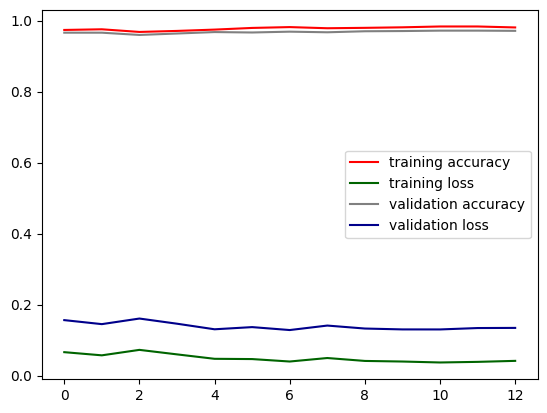

In [340]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
    mode='max'
)  

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weight_test.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

log = best_hb_model.fit(
    X_train_scaled,
    Y_train,
    epochs=100,
    batch_size=96,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=[early_stopping_cb, checkpoint],
    class_weight = class_weight
)
create_plot(log)

In [443]:
show_predicted_result(best_hb_model,X_test_scaled)

55/55 [==============================] - 1s 9ms/step
Mean square error:  0.03499539762198941
55/55 [==============================] - 0s 3ms/step
Threshold-------------------------: 0.98
Number of data in testset:--------: 1730
Number of predicted frauds--------: 20
Total number of frauds in testset-: 17
Number of predicted frauds hit----: 5
Hit rate--------------------------: 0.25
Detection rate--------------------: 0.011560693641618497


In [412]:
# save the best weights so far
best_hb_model.save_weights("best_weight")

# best hp : (24, 48, 0.6299999999999997, 0.06287028228888145, 'sgd')
best_hps["n_hiddens"], best_hps["n_neurons"], best_hps["dropout_rate"], best_hps["learning_rate"], best_hps["optimizer"]

(24, 48, 0.6299999999999997, 0.06287028228888145, 'sgd')

## Save the best model above

• Only need to run once


In [437]:
# tf.keras.models.save_model(best_hb_model, "best_hb_model")

INFO:tensorflow:Assets written to: best_hb_model/assets


INFO:tensorflow:Assets written to: best_hb_model/assets


## Loading the saved model to predict new data

In [11]:
final_model = tf.keras.models.load_model("best_hb_model")
final_model.load_weights("best_hb_model")

show_predicted_result(final_model, X_test_scaled)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-07 02:51:21.654320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-07 02:51:21.654496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 1/55 [..............................] - ETA: 7s

2023-03-07 02:51:22.580364: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open best_hb_model: FAILED_PRECONDITION: best_hb_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-03-07 02:51:22.646283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-07 02:51:22.701545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 0s 4ms/step
Mean square error:  0.03499539762198941
55/55 [==============================] - 0s 3ms/step
Threshold-------------------------: 0.98
Number of data in testset:--------: 1730
Number of predicted frauds--------: 20
Total number of frauds in testset-: 17
Number of predicted frauds hit----: 5
Hit rate--------------------------: 0.25
Detection rate--------------------: 0.011560693641618497


## Q6

In [12]:
# Divide fraudulent and non-fraudulent observations
df_frau = insurance_df.loc[insurance_df["Fraud"]==1]
df_nofr = insurance_df.loc[insurance_df["Fraud"]==0]
# Build X set and y set
X_frau = df_frau.drop(columns = ["Fraud"])
Y_frau = df_frau["Fraud"]
X_nofr = df_nofr.drop(columns = ["Fraud"])
Y_nofr = df_nofr["Fraud"]
print("X with fraud:", X_frau.shape)
print("X without fraud:", X_nofr.shape)
print("proportion:", X_frau.shape[0]/X_nofr.shape[0])

# Split Train & Other dataset without fraudulent observations
X_train, X_other, Y_train, Y_other = train_test_split(X_nofr, Y_nofr, test_size=0.4, random_state = 111)
print("Train:",X_train.shape)
print("Other:",X_other.shape)
# Split Vali & Test dataset without fraudulent observations
X_test_n, X_vali_n, Y_test_n, Y_vali_n = train_test_split(X_other, Y_other, test_size=0.3, random_state = 111)
print("Test_n:",X_test_n.shape)
print("Vali_n:", X_vali_n.shape)

# Split fraudulent observations equally
X_test_y, X_vali_y, Y_test_y, Y_vali_y = train_test_split(X_frau, Y_frau, test_size=0.3, random_state = 111)
print("Test_y:",X_test_y.shape)
print("Vali_y:", X_vali_y.shape)

# Concate observations with / without fraudulent observations in test & vali dataset
X_test = pd.concat([X_test_n, X_test_y], axis = 0, ignore_index = True)
Y_test = pd.concat([Y_test_n, Y_test_y], axis = 0, ignore_index = True)
X_vali = pd.concat([X_vali_n, X_vali_y], axis = 0, ignore_index = True)
Y_vali = pd.concat([Y_vali_n, Y_vali_y], axis = 0, ignore_index = True)

print("Test:",X_test.shape)
print("Vali:", X_vali.shape)

X with fraud: (115, 121)
X without fraud: (11415, 121)
proportion: 0.010074463425317565
Train: (6849, 121)
Other: (4566, 121)
Test_n: (3196, 121)
Vali_n: (1370, 121)
Test_y: (80, 121)
Vali_y: (35, 121)
Test: (3276, 121)
Vali: (1405, 121)


In [16]:
y_pred = final_model.predict(X_test.T)
y_pred = y_pred.ravel()

mse = np.sum((y_pred - Y_test) ** 2) / len(y_pred)
print("Mean square error: ", mse)

opt_thresh = opt_threshold(final_model) 

y_pred = [1 if p > opt_thresh else 0 for p in y_pred]

hits = sum(Y_test & y_pred)

hit_rate = hits / np.sum(y_pred)
detection_rate = np.sum(y_pred) / len(y_pred)

print("Threshold-------------------------:", opt_thresh)
print("Number of predicted frauds--------:", np.sum(y_pred))
print("Total number of frauds in testset-:", np.sum(Y_test))
print("Number of predicted frauds hit----:", hits)
print("Hit rate--------------------------:", hit_rate)
print("Detection rate--------------------:", detection_rate)

2023-03-07 02:55:33.028635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_15/flatten_15/Reshape' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_10508/4054905396.py", line 1, in <module>
      y_pred = final_model.predict(X_test.T)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_15/flatten_15/Reshape'
Input to reshape is a tensor with 104832 values, but the requested shape requires a multiple of 121
	 [[{{node sequential_15/flatten_15/Reshape}}]] [Op:__inference_predict_function_5654]